# Deep Q-Network Reinforcement Learning for the CartPole Environment

### Note

This Link notebook was adapted from Pytorch DQN Reinforce learning tutorial at
https://github.com/ritakurban/Practical-Data-Science/blob/master/DQL_CartPole.ipynb

### Required Python Packages
- `gym`
- `torch`
- `matplotlib`

Run the following cell to install the packages. 

In [ ]:
#
# Required Packages
#   Run this cell to install required packages
#
!pip install "gym>=0.21"
!pip install "torch>=1.9+cpu"
!pip install "matplotlib>=3.5"

In [1]:
import random

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython import display

## Environment

The CartPole environment consists of a pole which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. The state space is represented by four values: cart position, cart velocity, pole angle, and the velocity of the tip of the pole. The action space consists of two actions: moving left or moving right. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center. 

Source: [https://gym.openai.com/envs/CartPole-v1/](Open AI Gym). 

In [5]:
# Use Open-AI Gym Framework
# - CartPole environment
#   https://www.gymlibrary.ml/environments/classic_control/cart_pole/

env = gym.make("CartPole-v1")

# Rendering routine
def get_screen(env):
    """Extract one step of the simulation."""
    screen = env.render(mode="rgb_array").transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.0
    return torch.from_numpy(screen)

## Plotting Function

This function will make it possible to analyze how the agent learns over time. The resulting plot consists of two subplots. The first one plots the total reward the agent accumulates over time, while the other plot shows a histogram of the agent's total rewards for the last 100 episodes. 

In [5]:
def plot_res(values, title=""):
    """Plot the reward curve and histogram of results over time."""
    # Update the window after each episode
    display.clear_output(wait=True)

    # Two plots
    f, ax = plt.subplots(1, 2, figsize=(12, 5))
    f.suptitle(title)
    ax1, ax2 = ax

    # Reward curves
    ax1.plot(values, label="Score per Run")
    ax1.axhline(100, c="red", ls="--", label="Goal")
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel("Reward")
    ax1.legend()
    # Calculate the trend
    x = range(len(values))
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x, p(x), "--", label="trend")
    except:
        pass

    # Histogram of Rewards
    ax2.hist(values[-100:], bins=10)
    ax2.axvline(100, c="red", label="Goal")
    ax2.set_xlabel("Rewards for last 100 episodes")
    ax2.set_ylabel("Frequency")
    ax2.legend()
    plt.show()

## Random Search

Before implementing any deep learning approaches, I wrote a simple strategy where the action is sampled randomly from the action space. This approach will serve as a baseline for other strategies and will make it easier to understand how to work with the agent using the Open AI Gym environment.

In [ ]:
def random_search(env, episodes):
    final = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        total = 0
        while not done:
            # Sample random actions
            action = env.action_space.sample()
            # Take action and extract results
            next_state, reward, done, info = env.step(action)
            # Update reward
            total += reward
            get_screen(env)
            if done:
                break
        # Add to the final reward
        final.append(total)
        plot_res(final, title="Random Strategy")
    return final

The run below presents the random strategy. As expected, it's impossible to solve the environment using this approach. The agent is not learning from their experience. Despite being lucky sometimes (getting a reward of almost 75), their average performance is as low as 10 steps.

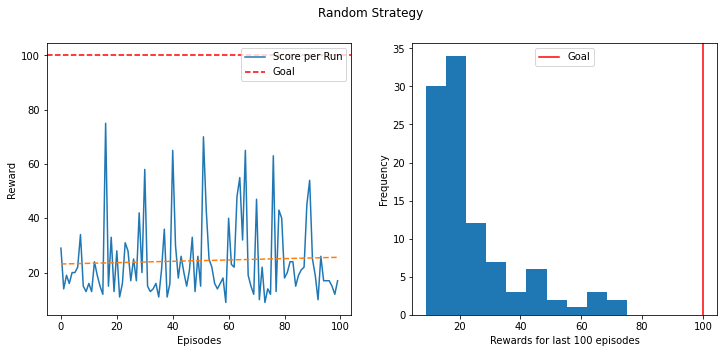

In [1]:
random_search(env, 100)
env.close()

## Deep Q Learning

The main idea behind Q-learning is that we have a function $Q: State \times Action \rightarrow \mathbb{R}$, which can tell the agent what actions will result in what rewards. If we know the value of Q, it is possible to construct a policy that maximizes rewards:

\begin{align}\pi(s) = \arg\!\max_a \ Q(s, a)\end{align}

However, in the real world, we don't have access to full information, that's why we need to come up with ways of approximating Q. One traditional method is creating a lookup table where the values of Q are updated after each of the agent's actions. However, this approach is slow and does not scale to large action and state spaces. Since neural networks are universal function approximators, I will train a network that can approximate $Q$.

The DQL class implementation consists of a simple neural network implemented in PyTorch that has two main methods--predict and update. The network takes the agent's state as an input and returns the Q values for each of the actions. The maximum Q value is selected by the agent to perform the next action.

In [ ]:
from torch.nn import LeakyReLU, Linear, Module, MSELoss, ReLU, Sequential


class DQN(Module):
    """Deep Q Neural Network"""

    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.01):
        super().__init__()
        self.criterion = MSELoss()
        self.model = Sequential(
            Linear(state_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, action_dim),
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def update(self, state, y):
        """Update the weights of networks given a training sample"""
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, torch.tensor(y, requires_grad=True))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, state):
        """Compute Q values for all actions"""
        with torch.no_grad():
            return self.model(torch.Tensor(state))

## Deep Q Network Training

The `q_learning` function is the main loop for all the algorithms that follow. 
It has many parameters, namely:

- Env represents the Open Ai Gym environment that we want to solve (CartPole.)
- Episodes stand for the number of games we want to play (from the beginning until the end.)
- Gamma is a discounting factor that is multiplied by future rewards to dampen these rewards' effect on the agent. It is designed to make future rewards worth less than immediate rewards.
- Epsilon represents the proportion of random actions relative to actions that are informed by existing "knowledge" that the agent accumulates during the episode. Before playing the game, the agent doesn't have any experience, so it is common to set epsilon to higher values and then gradually decrease its value.
- Eps_decay parameter indicates the speed at which the epsilon decreases as the agent learns. 0.99 comes from the original DQN paper.

I will explain other parameters later on when we will get to the corresponding agents.
The most straightforward agent updates its Q-values based on its most recent observation. It doesn't have any memory, but it learns by first exploring the environment and the gradually decreasing its epsilon value to make informed decisions:

In [12]:
def q_learning(env, model, n_episode, gamma=0.9, epsilon=0.5, eps_decay=0.99, replay=True, replay_size=50):
    """Deep Q Learning algorithm"""
    final = []
    memory = []
    for episode in range(n_episode):
        # Reset state
        state = env.reset()
        done = False
        total = 0

        while not done:
            # Greedy search policy
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()

            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            total += reward
            q_values = model.predict(state).tolist()

            # Store to memory
            memory.append((state, action, next_state, reward, done))

            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            # Show environment
            get_screen(env)

            if replay:
                # Update network weights using replay memory
                replay_update(model, memory, size=replay_size, gamma=gamma)
            else:
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state

        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, "DQN Learning")

    return final

## Train DQN with a single-per-step data

The run below shows that the performance of the agent has significantly improved. It got to 100 steps, which, as we've seen before, is impossible for a random agent. The trend line is also positive, and we can see that the performance increases over time. At the same time, its average performance is still around 20 steps, so there is definitely enough room for improvement.

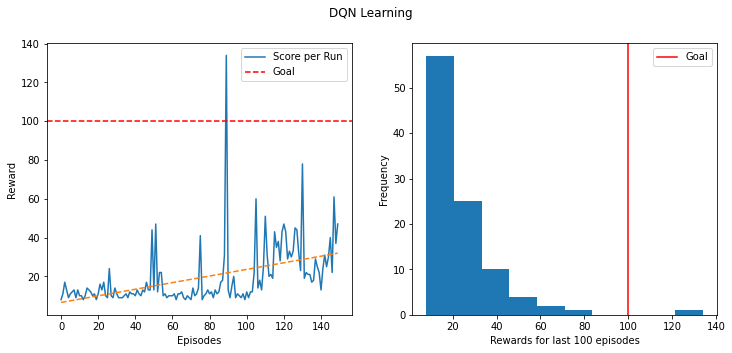

In [2]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 100
lr = 0.001
n_episode = 150
epsilon = 0.3
eps_decay = 0.99

model = DQN(state_dim=state_dim, action_dim=action_dim, hidden_dim=hidden_dim, lr=lr)
q_learning(env, model, n_episode=n_episode, epsilon=epsilon, eps_decay=eps_decay, replay=False)
env.close()

## Replay

The approximation of Q using one sample at a time is not very effective. The graph above is a nice illustration of that. The network managed to achieve a much better performance compared to a random agent. However, it couldn't get to the threshold line of 195 steps. I implemented experience replay to improve network stability and make sure previous experiences are not discarded but used in training.

Experience replay stores the agent's experiences in memory. Batches of experiences are randomly sampled from memory and are used to train the neural network. Such learning consists of two phases--gaining experience and updating the model. The size of the replay controls the number of experiences that are used for the network update. Memory is an array that stores the agent's state, reward, and action, as well as whether the action finished the game and the next state.

In [22]:
def replay_update(model, memory, size, gamma=0.9):
    """Use replay buffer for accumulation of experience"""
    if len(memory) <= size:
        return
    states = []
    targets = []
    # Sample a batch of experiences from the agent's memory
    batch = random.sample(memory, size)
    # Extract information from data
    for state, action, next_state, reward, done in batch:
        states.append(state)
        q_values = model.predict(state)
        if done:
            q_values[action] = reward
        else:
            q_values_next = model.predict(next_state)
            q_values[action] = reward + gamma * torch.max(q_values_next).item()
        targets.append(q_values.tolist())
    model.update(states, targets)

## Train DQN with Replay Data
As below, neural network training with the replay seems to be much more robust and smart compared to its counterpart that only remembers the last action. After approximately 60 episodes, the agent managed to achieve the winning threshold and remain at this level. I also managed to achieve the highest reward possible--500.

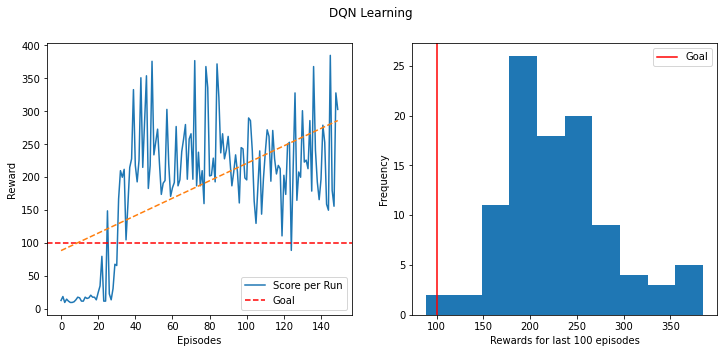

In [3]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 100
lr = 0.001
n_episode = 150
epsilon = 0.3
eps_decay = 0.99
replay_size = 30

model = DQN(state_dim=state_dim, action_dim=action_dim, hidden_dim=hidden_dim, lr=lr)
q_learning(env, model, n_episode=n_episode, epsilon=epsilon, eps_decay=eps_decay, replay=True, replay_size=replay_size)
env.close()